In [1]:
!pip install pot
!pip install torch
!pip install geomloss
!pip install wget


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd

from geomloss import SamplesLoss

import ot

import os
import pickle as pkl
import copy

from sklearn.preprocessing import scale
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from utils import *
from SoftImpute import softimpute, cv_softimpute
from DataSetLoader import dataset_loader, ground_truth
from SinkhornImputation import SinkhornImputation
import matplotlib.pyplot as plt

import argparse
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

torch.set_default_tensor_type('torch.DoubleTensor')

c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
germanMCAR10 = scale(dataset_loader("germanMCAR10"))
germanMCAR15 = scale(dataset_loader("germanMCAR15"))
germanMCAR20 = scale(dataset_loader("germanMCAR20"))
germanMCAR25 = scale(dataset_loader("germanMCAR25"))
germanMCAR30 = scale(dataset_loader("germanMCAR30"))
print(type(germanMCAR10))
print(type(germanMCAR15))
print(type(germanMCAR20))
print(type(germanMCAR25))
print(type(germanMCAR30))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [4]:
groundTruth = scale(ground_truth("german_credit"))
print(type(groundTruth))

<class 'numpy.ndarray'>


In [5]:
print(groundTruth.shape)
#print(groundTruth.isnull().sum())

(1000, 9)


In [6]:

german_mcar10= torch.tensor(germanMCAR10, dtype=torch.double) 
german_mcar15= torch.tensor(germanMCAR15, dtype=torch.double) 
german_mcar20= torch.tensor(germanMCAR20, dtype=torch.double) 
german_mcar25= torch.tensor(germanMCAR25, dtype=torch.double) 
german_mcar30= torch.tensor(germanMCAR30, dtype=torch.double) 
german_ground_truth = torch.tensor(groundTruth, dtype=torch.double) 

In [7]:
print(german_mcar30)

tensor([[    nan,  0.6532,  0.1547,  ...,     nan, -1.1988,  1.0876],
        [-1.1875,     nan,  0.1547,  ...,     nan,     nan,  1.0876],
        [    nan,     nan,     nan,  ..., -0.3965, -0.7119,  0.0747],
        ...,
        [ 0.1994,  0.6532,  0.1547,  ..., -0.8550,     nan,  1.0876],
        [-1.1008,  0.6532,  0.1547,  ...,     nan,  1.9665,  1.0876],
        [-0.7541,  0.6532,  0.1547,  ...,  0.4837,  1.9665, -0.9382]])


In [8]:
print(german_ground_truth.isnan().sum())

tensor(0)


In [9]:
print(german_mcar30.shape)
print(german_mcar30.isnan().sum())  # Check for missing values


torch.Size([1000, 9])
tensor(3000)


**MCAR 10%**

In [79]:
n_mcar10, d_mcar10 = german_mcar10.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar10 = pick_epsilon(german_mcar10)/100
#epsilon_mcar10 = 0.09

print(epsilon_mcar10)

tensor([-7.8546e-17, -4.8612e-17, -4.4919e-17,  1.7050e-16, -1.1674e-17,
        -3.4679e-17,  7.9926e-18, -9.9468e-17, -8.1954e-17])
0.07058523312633766


In [80]:
sk_imputer_mcar10 = SinkhornImputation(eps=epsilon_mcar10, batchsize=batchsize, lr=lr, niter=5000)

In [82]:
X = german_mcar10.clone()
sk_imp_mcar10, sk_maes, sk_rmses = sk_imputer_mcar10.fit_transform(X, verbose=True, report_interval=500, X_true=german_ground_truth.clone())

INFO:root:batchsize = 128, epsilon = 0.0706
INFO:root:Iteration 0:	 Loss: 1.9092	 Validation MAE: 0.7519	RMSE: 0.9873
INFO:root:Iteration 500:	 Loss: 1.7387	 Validation MAE: 0.6881	RMSE: 1.0024
INFO:root:Iteration 1000:	 Loss: 1.6475	 Validation MAE: 0.6933	RMSE: 1.0218
INFO:root:Iteration 1500:	 Loss: 1.6621	 Validation MAE: 0.7047	RMSE: 1.0347
INFO:root:Iteration 2000:	 Loss: 1.9166	 Validation MAE: 0.7045	RMSE: 1.0337
INFO:root:Iteration 2500:	 Loss: 1.7488	 Validation MAE: 0.7036	RMSE: 1.0363
INFO:root:Iteration 3000:	 Loss: 1.7174	 Validation MAE: 0.6993	RMSE: 1.0299
INFO:root:Iteration 3500:	 Loss: 1.6383	 Validation MAE: 0.7003	RMSE: 1.0311
INFO:root:Iteration 4000:	 Loss: 1.5992	 Validation MAE: 0.7042	RMSE: 1.0375
INFO:root:Iteration 4500:	 Loss: 1.7189	 Validation MAE: 0.6974	RMSE: 1.0319


In [83]:
print(sk_imp_mcar10)

tensor([[-0.1290,  0.6741,  0.1485,  ..., -0.7494, -1.2548,  1.0728],
        [-1.1893, -1.4835,  0.1485,  ...,  0.9752,  0.2953,  1.0728],
        [-0.0388,  0.6741, -1.3712,  ..., -0.4151, -0.7586,  0.0596],
        ...,
        [ 0.1982,  0.6741,  0.1823,  ..., -0.8811, -0.7586,  1.0728],
        [-1.1026,  0.6741,  0.1485,  ..., -0.5056,  1.9702,  1.0728],
        [-0.7557,  0.6741,  0.1485,  ...,  0.4442,  1.9702,  0.8120]],
       grad_fn=<IndexPutBackward0>)


In [84]:
# Use detach() to remove the tensor from the computation graph
sk_imp_mcar10_numpy = sk_imp_mcar10.detach().cpu().numpy()


In [85]:
print(sk_imp_mcar10_numpy)

[[-0.12900459  0.67408805  0.14847869 ... -0.74941258 -1.25479058
   1.07283592]
 [-1.18929091 -1.48348574  0.14847869 ...  0.97522256  0.2952579
   1.07283592]
 [-0.03881917  0.67408805 -1.37124441 ... -0.4150887  -0.75863662
   0.059602  ]
 ...
 [ 0.19821515  0.67408805  0.18225153 ... -0.88105035 -0.75863662
   1.07283592]
 [-1.10257178  0.67408805  0.14847869 ... -0.50561221  1.97021016
   1.07283592]
 [-0.75569527  0.67408805  0.14847869 ...  0.4441589   1.97021016
   0.81198159]]


In [86]:
mask_mcar10 = pd.isna(germanMCAR10)
print(mask_mcar10)

[[ True False False ... False False False]
 [False False False ... False  True False]
 [ True False False ... False False False]
 ...
 [False False  True ... False False False]
 [False False False ... False False False]
 [False False False ...  True False  True]]


In [87]:
sk_mae_mcar10 = MAE(sk_imp_mcar10_numpy,groundTruth,mask_mcar10)
sk_rmse_mcar10 = RMSE(sk_imp_mcar10_numpy,groundTruth,mask_mcar10)
print(sk_mae_mcar10,sk_rmse_mcar10)

0.7029073274734362 1.0395508630953314


In [88]:
mean_mcar10 = germanMCAR10.copy()
mean_imp_mcar10 = SimpleImputer().fit_transform(mean_mcar10)
mean_mae_mcar10 = MAE(mean_imp_mcar10, groundTruth, mask_mcar10)
mean_rmse_mcar10= RMSE(mean_imp_mcar10, groundTruth, mask_mcar10)
print(mean_mae_mcar10, mean_rmse_mcar10)

0.7429375538470947 0.9826083285564635


In [89]:
# ICE
ice_mcar10 = germanMCAR10.copy()
ice_imp_mcar10 = IterativeImputer(random_state=0, max_iter=500).fit_transform(ice_mcar10)
ice_mae_mcar10 = MAE(ice_imp_mcar10, groundTruth, mask_mcar10)
ice_rmse_mcar10 = RMSE(ice_imp_mcar10, groundTruth, mask_mcar10)
print(ice_mae_mcar10,ice_rmse_mcar10)

0.6980232739336911 0.9239878081922045


In [90]:
#Softimpute
soft_mcar10 = germanMCAR10.copy()
cv_error_mcar10, grid_lambda_mcar10 = cv_softimpute(soft_mcar10, grid_len=15)
lbda_mcar10 = grid_lambda_mcar10[np.argmin(cv_error_mcar10)]
soft_imp_mcar10 = softimpute((soft_mcar10), lbda_mcar10)[1]

soft_mae_mcar10 = MAE(soft_imp_mcar10, groundTruth, mask_mcar10)
soft_rmse_mcar10 = RMSE(soft_imp_mcar10, groundTruth, mask_mcar10)
print(soft_mae_mcar10,soft_rmse_mcar10)

0.7022462376608108 0.931169987009942


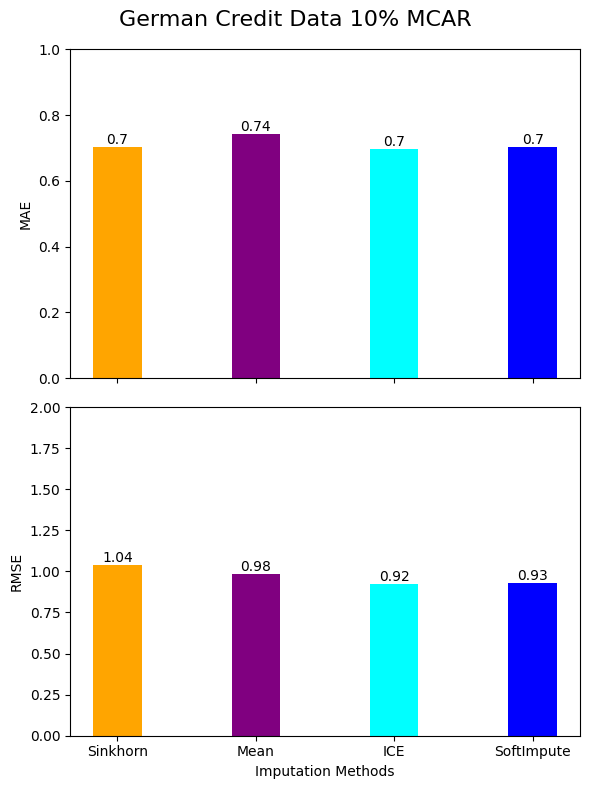

In [91]:

# Define values and categories
values_mae_mcar10 = [sk_mae_mcar10, mean_mae_mcar10, ice_mae_mcar10, soft_mae_mcar10]
values_rmse_mcar10 = [sk_rmse_mcar10, mean_rmse_mcar10, ice_rmse_mcar10, soft_rmse_mcar10]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig.suptitle('German Credit Data 10% MCAR', fontsize=16)

# Plot Mean MAE bars and add values on top
bars1 = ax1.bar(index, values_mae_mcar10, color=colors, width=bar_width)
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1)  # Adjust based on your data
for bar in bars1:
    yval = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Plot Mean RMSE bars and add values on top
bars2 = ax2.bar(index, values_rmse_mcar10, color=colors, width=bar_width)
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
for bar in bars2:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

# Label x-axis with categories
ax2.set_xticks(index)
ax2.set_xticklabels(categories)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


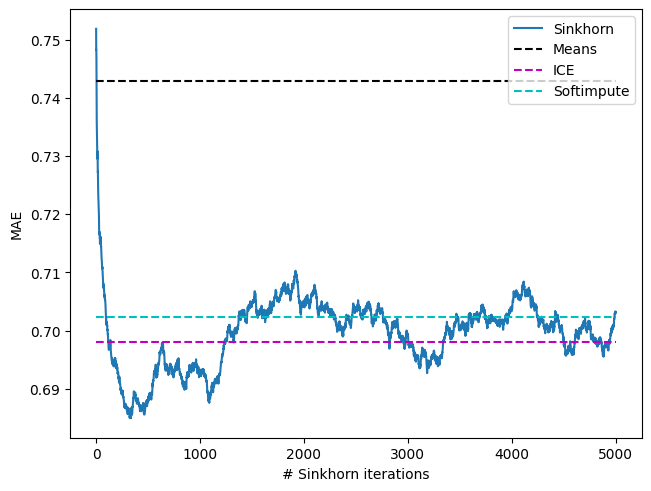

In [92]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_maes)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_maes, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_mae_mcar10, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_mae_mcar10, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_mae_mcar10, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

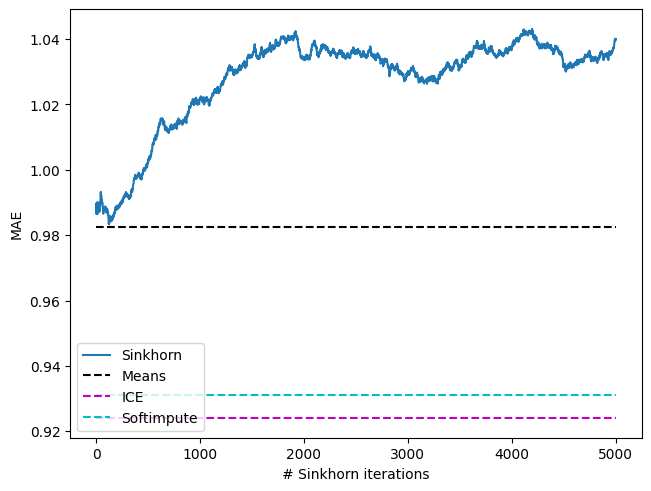

In [93]:
fig, ax = plt.subplots(constrained_layout=True)
npoints = len(sk_rmses)

ax.plot(np.linspace(0, 1, npoints) * npoints, sk_rmses, label='Sinkhorn')
ax.set_xticks(np.linspace(0, npoints, 6))
ax.set_xlabel('# Sinkhorn iterations')

ax.hlines(y=mean_rmse_mcar10, xmin=0, xmax=npoints, label="Means", ls = '--', color='black')
ax.hlines(y=ice_rmse_mcar10, xmin=0, xmax=npoints, label="ICE", ls = '--', color='m')
ax.hlines(y=soft_rmse_mcar10, xmin=0, xmax=npoints, label="Softimpute", ls = '--', color='c')

ax.set_ylabel('MAE')
plt.legend()
plt.show()

**15% MCAR**

In [ ]:
n_mcar15, d_mcar15 = german_mcar15.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar15 = pick_epsilon(german_mcar15)
print(epsilon_mcar15)
sk_imputer_mcar15 = SinkhornImputation(eps=epsilon_mcar15, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar15, sk_maes, sk_rmses = sk_imputer_mcar15.fit_transform(german_mcar15, verbose=True, report_interval=500, X_true=german_ground_truth)
print(sk_imp_mcar15)
sk_imp_mcar15_numpy = sk_imp_mcar15.detach().cpu().numpy()
print(sk_imp_mcar15_numpy)


INFO:root:batchsize = 128, epsilon = 6.6027
INFO:root:Iteration 0:	 Loss: 0.0547	 Validation MAE: 0.7624	RMSE: 1.0046


tensor([-1.5343e-16, -8.6231e-18, -1.2137e-16,  1.2116e-16,  4.0977e-17,
        -3.9519e-17, -6.6829e-17, -1.0766e-17, -1.6387e-17])
6.602674636991838


INFO:root:Iteration 500:	 Loss: 0.0916	 Validation MAE: 0.7992	RMSE: 1.0404
INFO:root:Iteration 1000:	 Loss: 0.0399	 Validation MAE: 0.8000	RMSE: 1.0362
INFO:root:Iteration 1500:	 Loss: 0.0186	 Validation MAE: 0.8156	RMSE: 1.0496


tensor([[ 2.6736,  0.6543,  0.1323,  ..., -0.7517, -0.7083,  1.0660],
        [-1.2003, -1.5284,  0.1323,  ...,  0.0327,  2.2031,  1.0660],
        [ 1.1240, -0.0885, -1.3888,  ..., -0.4173, -0.7310,  0.0565],
        ...,
        [ 0.1771,  0.6543,  0.1323,  ..., -0.8834, -0.7310,  1.0660],
        [-1.1142,  0.6543,  0.1323,  ..., -0.1746,  1.9586,  1.0660],
        [-0.7698,  0.6543,  0.1323,  ...,  0.4773,  1.9586, -0.9530]],
       grad_fn=<IndexPutBackward0>)
[[ 2.67357488  0.65427537  0.13227103 ... -0.75170171 -0.70832922
   1.06604186]
 [-1.20027583 -1.52840845  0.13227103 ...  0.03270777  2.20313695
   1.06604186]
 [ 1.1240346  -0.08845377 -1.38884584 ... -0.41729899 -0.73095423
   0.0564996 ]
 ...
 [ 0.17709331  0.65427537  0.13227103 ... -0.88337052 -0.73095423
   1.06604186]
 [-1.11419026  0.65427537  0.13227103 ... -0.17458948  1.95862935
   1.06604186]
 [-0.76984797  0.65427537  0.13227103 ...  0.47732747  1.95862935
  -0.95304267]]


In [ ]:
mask_mcar15 = pd.isna(germanMCAR15)
print(mask_mcar15)

[[False False False ... False  True False]
 [False False False ...  True False False]
 [False  True False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ...  True False False]
 [False False False ... False False False]]


In [ ]:
sk_mae_mcar15 = MAE(sk_imp_mcar15_numpy,groundTruth,mask_mcar15)
sk_rmse_mcar15 = RMSE(sk_imp_mcar15_numpy,groundTruth,mask_mcar15)
print(sk_mae_mcar15,sk_rmse_mcar15)

0.8171856583764164 1.048903008410281


In [ ]:
#mean
mean_imp_mcar15 = SimpleImputer().fit_transform(germanMCAR15)
mean_mae_mcar15 = MAE(mean_imp_mcar15, groundTruth, mask_mcar15)
mean_rmse_mcar15= RMSE(mean_imp_mcar15, groundTruth, mask_mcar15)
print(mean_mae_mcar15, mean_rmse_mcar15)

# ICE
ice_imp_mcar15 = IterativeImputer(random_state=0, max_iter=500).fit_transform(germanMCAR15)
ice_mae_mcar15 = MAE(ice_imp_mcar15, groundTruth, mask_mcar15)
ice_rmse_mcar15 = RMSE(ice_imp_mcar15, groundTruth, mask_mcar15)
print(ice_mae_mcar15,ice_rmse_mcar15)

#Softimpute
cv_error_mcar15, grid_lambda_mcar15 = cv_softimpute(germanMCAR15, grid_len=15)
lbda_mcar15 = grid_lambda_mcar15[np.argmin(cv_error_mcar15)]
soft_imp_mcar15 = softimpute((germanMCAR15), lbda_mcar15)[1]

soft_mae_mcar15 = MAE(soft_imp_mcar15, groundTruth, mask_mcar15)
soft_rmse_mcar15 = RMSE(soft_imp_mcar15, groundTruth, mask_mcar15)
print(soft_mae_mcar15,soft_rmse_mcar15)

0.7546523613324279 0.9946629664720809
0.7151824886149847 0.9417488127409382
0.7183995810773095 0.945796386134248


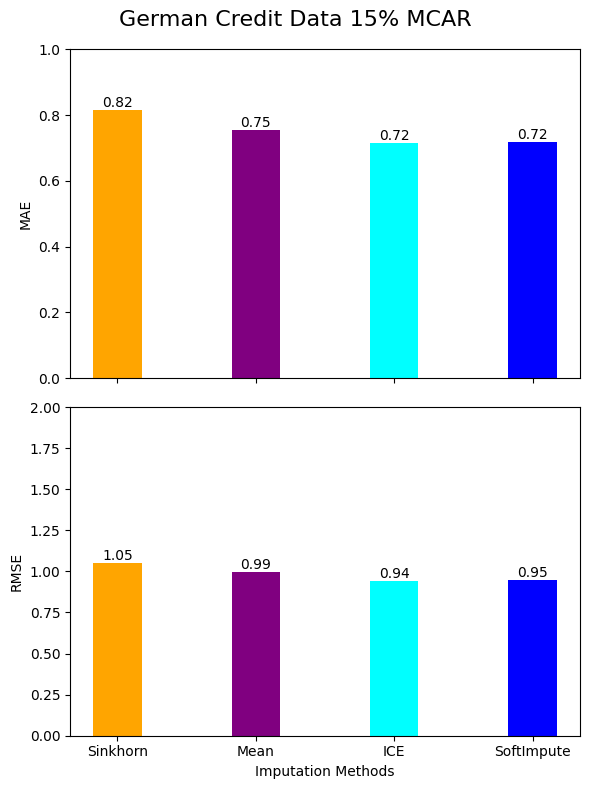

In [ ]:

# Define values and categories
values_mae_mcar15 = [sk_mae_mcar15, mean_mae_mcar15, ice_mae_mcar15, soft_mae_mcar15]
values_rmse_mcar15 = [sk_rmse_mcar15, mean_rmse_mcar15, ice_rmse_mcar15, soft_rmse_mcar15]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig2.suptitle('German Credit Data 15% MCAR', fontsize=16)

bars3 = ax3.bar(index, values_mae_mcar15, color=colors, width=bar_width)
ax3.set_ylabel("MAE")
ax3.set_ylim(0, 1)  # Adjust based on your data
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

bars4 = ax4.bar(index, values_rmse_mcar15, color=colors, width=bar_width)
ax4.set_ylabel("RMSE")
ax4.set_ylim(0, 2)  # Adjust based on your data
for bar in bars4:
    yval = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

ax4.set_xticks(index)
ax4.set_xticklabels(categories)
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**20% MCAR**

In [ ]:
n_mcar20, d_mcar20 = german_mcar20.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar20 = pick_epsilon(german_mcar20)
print(epsilon_mcar20)
sk_imputer_mcar20 = SinkhornImputation(eps=epsilon_mcar20, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar20, sk_maes, sk_rmses = sk_imputer_mcar20.fit_transform(german_mcar20, verbose=True, report_interval=500, X_true=german_ground_truth)
print(sk_imp_mcar20)
sk_imp_mcar20_numpy = sk_imp_mcar20.detach().cpu().numpy()
print(sk_imp_mcar20_numpy)


INFO:root:batchsize = 128, epsilon = 6.2238
INFO:root:Iteration 0:	 Loss: 0.0934	 Validation MAE: 0.7236	RMSE: 0.9678


tensor([ 1.6617e-16, -1.6107e-17,  7.9723e-17,  4.2406e-17,  2.1903e-17,
         8.4938e-17,  9.5491e-17,  1.4240e-16, -1.0546e-16])
6.2238087128726445


INFO:root:Iteration 500:	 Loss: 0.0901	 Validation MAE: 0.7608	RMSE: 1.0002
INFO:root:Iteration 1000:	 Loss: 0.0565	 Validation MAE: 0.7688	RMSE: 1.0077
INFO:root:Iteration 1500:	 Loss: 0.0486	 Validation MAE: 0.7785	RMSE: 1.0182


tensor([[ 0.0081,  0.6737,  0.1410,  ..., -0.7567,  0.0786,  1.0482],
        [-1.1898, -0.2221,  0.1410,  ...,  0.9545,  0.7069, -0.4703],
        [ 0.1586,  0.6737, -1.3457,  ...,  0.2711, -0.7273, -0.0266],
        ...,
        [ 0.2142, -0.1544,  0.1410,  ..., -0.8873, -0.7273,  1.0482],
        [-0.5580,  0.6737, -0.0085,  ..., -0.5148,  1.9878,  1.0482],
        [-0.7510,  0.6737,  0.1410,  ...,  0.7404,  1.9878, -0.9697]],
       grad_fn=<IndexPutBackward0>)
[[ 0.00810931  0.6736918   0.14096101 ... -0.75668136  0.07864984
   1.04822349]
 [-1.1897546  -0.22214763  0.14096101 ...  0.95445488  0.70690648
  -0.47029567]
 [ 0.15855164  0.6736918  -1.34570776 ...  0.27114826 -0.72728777
  -0.02663395]
 ...
 [ 0.21422751 -0.15437092  0.14096101 ... -0.88728879 -0.72728777
   1.04822349]
 [-0.55802246  0.6736918  -0.00846889 ... -0.51478924  1.98780067
   1.04822349]
 [-0.75101019  0.6736918   0.14096101 ...  0.74035954  1.98780067
  -0.96968992]]


In [ ]:
mask_mcar20 = pd.isna(germanMCAR20)
print(mask_mcar20)

[[ True False False ... False  True False]
 [False  True False ... False  True  True]
 [ True False False ...  True False  True]
 ...
 [False  True False ... False False False]
 [ True False  True ... False False False]
 [False False False ...  True False False]]


In [ ]:
sk_mae_mcar20 = MAE(sk_imp_mcar20_numpy,groundTruth,mask_mcar20)
sk_rmse_mcar20 = RMSE(sk_imp_mcar20_numpy,groundTruth,mask_mcar20)
print(sk_mae_mcar20,sk_rmse_mcar20)

0.7858676682123171 1.0238782004249993


In [ ]:
#mean
mean_imp_mcar20 = SimpleImputer().fit_transform(germanMCAR20)
mean_mae_mcar20 = MAE(mean_imp_mcar20, groundTruth, mask_mcar20)
mean_rmse_mcar20= RMSE(mean_imp_mcar20, groundTruth, mask_mcar20)
print(mean_mae_mcar20, mean_rmse_mcar20)

# ICE
ice_imp_mcar20 = IterativeImputer(random_state=0, max_iter=500).fit_transform(germanMCAR20)
ice_mae_mcar20 = MAE(ice_imp_mcar20, groundTruth, mask_mcar20)
ice_rmse_mcar20 = RMSE(ice_imp_mcar20, groundTruth, mask_mcar20)
print(ice_mae_mcar20,ice_rmse_mcar20)

#Softimpute
cv_error_mcar20, grid_lambda_mcar20 = cv_softimpute(germanMCAR20, grid_len=15)
lbda_mcar20 = grid_lambda_mcar20[np.argmin(cv_error_mcar20)]
soft_imp_mcar20 = softimpute((germanMCAR20), lbda_mcar20)[1]

soft_mae_mcar20 = MAE(soft_imp_mcar20, groundTruth, mask_mcar20)
soft_rmse_mcar20 = RMSE(soft_imp_mcar20, groundTruth, mask_mcar20)
print(soft_mae_mcar20,soft_rmse_mcar20)

0.7221835185114197 0.9657351849848589
0.6894259358474357 0.9087058941838358
0.6907548429407595 0.9227020915889595


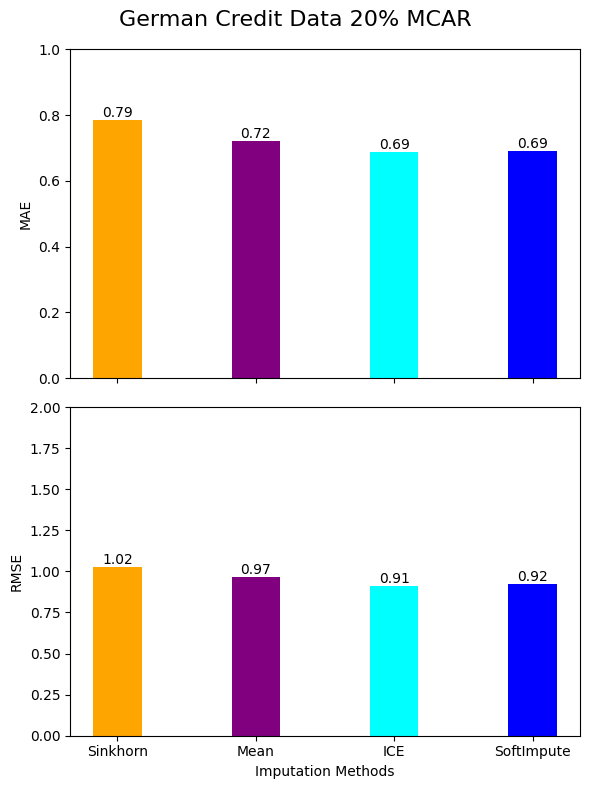

In [ ]:

# Define values and categories
values_mae_mcar20 = [sk_mae_mcar20, mean_mae_mcar20, ice_mae_mcar20, soft_mae_mcar20]
values_rmse_mcar20 = [sk_rmse_mcar20, mean_rmse_mcar20, ice_rmse_mcar20, soft_rmse_mcar20]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig2.suptitle('German Credit Data 20% MCAR', fontsize=16)

bars3 = ax3.bar(index, values_mae_mcar20, color=colors, width=bar_width)
ax3.set_ylabel("MAE")
ax3.set_ylim(0, 1)  # Adjust based on your data
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

bars4 = ax4.bar(index, values_rmse_mcar20, color=colors, width=bar_width)
ax4.set_ylabel("RMSE")
ax4.set_ylim(0, 2)  # Adjust based on your data
for bar in bars4:
    yval = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

ax4.set_xticks(index)
ax4.set_xticklabels(categories)
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**25% MCAR**

In [ ]:
n_mcar25, d_mcar25 = german_mcar25.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar25 = pick_epsilon(german_mcar25)
print(epsilon_mcar25)
sk_imputer_mcar25 = SinkhornImputation(eps=epsilon_mcar25, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar25, sk_maes, sk_rmses = sk_imputer_mcar25.fit_transform(german_mcar25, verbose=True, report_interval=500, X_true=german_ground_truth)
print(sk_imp_mcar25)
sk_imp_mcar25_numpy = sk_imp_mcar25.detach().cpu().numpy()
print(sk_imp_mcar25_numpy)


INFO:root:batchsize = 128, epsilon = 5.6647
INFO:root:Iteration 0:	 Loss: 0.0477	 Validation MAE: 0.7626	RMSE: 0.9965


tensor([-2.9688e-17,  9.1191e-17, -1.5358e-17,  1.5248e-16, -2.7864e-17,
        -5.2246e-17,  1.2492e-17,  8.5668e-17,  9.9121e-17])
5.664749268261085


INFO:root:Iteration 500:	 Loss: 0.0680	 Validation MAE: 0.7999	RMSE: 1.0243
INFO:root:Iteration 1000:	 Loss: 0.0584	 Validation MAE: 0.8036	RMSE: 1.0304
INFO:root:Iteration 1500:	 Loss: 0.0352	 Validation MAE: 0.8132	RMSE: 1.0405


tensor([[-0.0379,  0.6431,  0.1607,  ..., -0.7241, -1.2574,  1.0478],
        [-1.1949, -1.5551,  0.0358,  ...,  0.9710,  2.2589,  1.0478],
        [-0.1013, -0.3911, -0.1823,  ..., -0.3955,  0.1083,  0.1922],
        ...,
        [ 0.2203,  0.6431,  0.2059,  ..., -0.8535,  0.2371,  1.0478],
        [-1.1064, -0.6505,  0.1607,  ..., -0.4845,  2.0078,  1.0478],
        [-0.7527,  0.6431,  0.1966,  ...,  0.0651,  0.3467, -0.9622]],
       grad_fn=<IndexPutBackward0>)
[[-0.03788585  0.64305434  0.16070526 ... -0.72407913 -1.25735409
   1.04777846]
 [-1.19488846 -1.55507853  0.03579625 ...  0.97102237  2.25891476
   1.04777846]
 [-0.10132251 -0.39111853 -0.18231625 ... -0.39548041  0.10828223
   0.19218263]
 ...
 [ 0.22025367  0.64305434  0.20592871 ... -0.85346266  0.23706154
   1.04777846]
 [-1.10644208 -0.65054502  0.16070526 ... -0.48445374  2.0077527
   1.04777846]
 [-0.75265654  0.64305434  0.19663083 ...  0.06507612  0.34673719
  -0.96218529]]


In [ ]:
mask_mcar25 = pd.isna(germanMCAR25)
print(mask_mcar25)

[[ True False False ... False False False]
 [False False  True ... False False False]
 [ True  True  True ... False  True  True]
 ...
 [False False  True ... False  True False]
 [False  True False ... False False False]
 [False False  True ...  True  True False]]


In [ ]:
sk_mae_mcar25 = MAE(sk_imp_mcar25_numpy,groundTruth,mask_mcar25)
sk_rmse_mcar25 = RMSE(sk_imp_mcar25_numpy,groundTruth,mask_mcar25)
print(sk_mae_mcar25,sk_rmse_mcar25)

0.8131931277133461 1.0410170680887347


In [ ]:
#mean
mean_imp_mcar25 = SimpleImputer().fit_transform(germanMCAR25)
mean_mae_mcar25 = MAE(mean_imp_mcar25, groundTruth, mask_mcar25)
mean_rmse_mcar25= RMSE(mean_imp_mcar25, groundTruth, mask_mcar25)
print(mean_mae_mcar25, mean_rmse_mcar25)

# ICE
ice_imp_mcar25 = IterativeImputer(random_state=0, max_iter=500).fit_transform(germanMCAR25)
ice_mae_mcar25 = MAE(ice_imp_mcar25, groundTruth, mask_mcar25)
ice_rmse_mcar25 = RMSE(ice_imp_mcar25, groundTruth, mask_mcar25)
print(ice_mae_mcar25,ice_rmse_mcar25)

#Softimpute
cv_error_mcar25, grid_lambda_mcar25 = cv_softimpute(germanMCAR25, grid_len=15)
lbda_mcar25 = grid_lambda_mcar25[np.argmin(cv_error_mcar25)]
soft_imp_mcar25 = softimpute((germanMCAR25), lbda_mcar25)[1]

soft_mae_mcar25 = MAE(soft_imp_mcar25, groundTruth, mask_mcar25)
soft_rmse_mcar25 = RMSE(soft_imp_mcar25, groundTruth, mask_mcar25)
print(soft_mae_mcar25,soft_rmse_mcar25)

0.7616328055230391 0.995054579041171
0.7370292556004084 0.9494193827614901
0.7355351728579581 0.9553265550089747


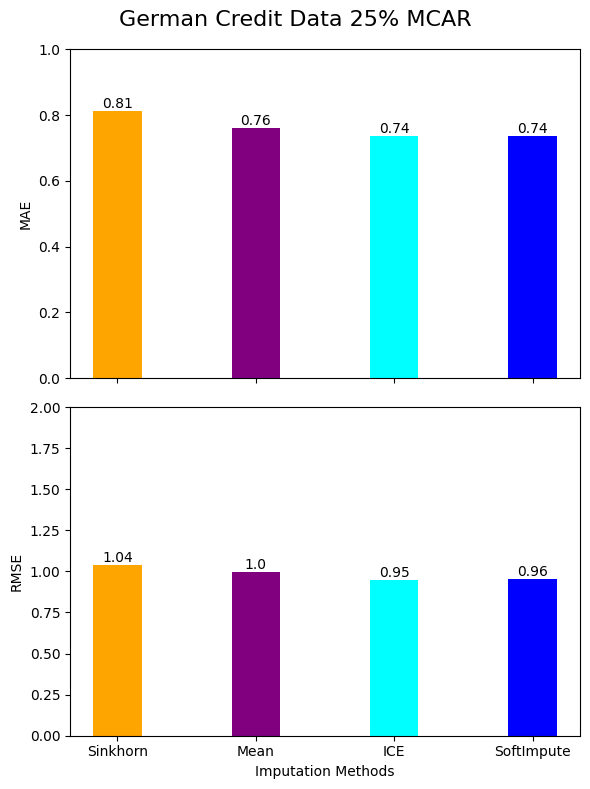

In [ ]:

# Define values and categories
values_mae_mcar25 = [sk_mae_mcar25, mean_mae_mcar25, ice_mae_mcar25, soft_mae_mcar25]
values_rmse_mcar25 = [sk_rmse_mcar25, mean_rmse_mcar25, ice_rmse_mcar25, soft_rmse_mcar25]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig2.suptitle('German Credit Data 25% MCAR', fontsize=16)

bars3 = ax3.bar(index, values_mae_mcar25, color=colors, width=bar_width)
ax3.set_ylabel("MAE")
ax3.set_ylim(0, 1)  # Adjust based on your data
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

bars4 = ax4.bar(index, values_rmse_mcar25, color=colors, width=bar_width)
ax4.set_ylabel("RMSE")
ax4.set_ylim(0, 2)  # Adjust based on your data
for bar in bars4:
    yval = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

ax4.set_xticks(index)
ax4.set_xticklabels(categories)
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


**30% MCAR**

In [ ]:
n_mcar30, d_mcar30 = german_mcar30.shape
batchsize = 128 # If the batch size is larger than half the dataset's size,
                # it will be redefined in the imputation methods.
lr = 1e-2
epsilon_mcar30 = pick_epsilon(german_mcar30)
print(epsilon_mcar30)
sk_imputer_mcar30 = SinkhornImputation(eps=epsilon_mcar30, batchsize=batchsize, lr=lr, niter=2000)
sk_imp_mcar30, sk_maes, sk_rmses = sk_imputer_mcar30.fit_transform(german_mcar30, verbose=True, report_interval=500, X_true=german_ground_truth)
print(sk_imp_mcar30)
sk_imp_mcar30_numpy = sk_imp_mcar30.detach().cpu().numpy()
print(sk_imp_mcar30_numpy)


INFO:root:batchsize = 128, epsilon = 5.2003
INFO:root:Iteration 0:	 Loss: 0.0256	 Validation MAE: 0.7527	RMSE: 0.9871


tensor([-1.3057e-16, -1.8783e-16,  3.0723e-17, -6.3249e-17, -5.4353e-17,
        -7.3823e-17, -4.5964e-17, -5.6125e-17, -6.6200e-17])
5.200340364719957


INFO:root:Iteration 500:	 Loss: 0.0733	 Validation MAE: 0.7843	RMSE: 1.0167
INFO:root:Iteration 1000:	 Loss: 0.0401	 Validation MAE: 0.7883	RMSE: 1.0194
INFO:root:Iteration 1500:	 Loss: 0.0611	 Validation MAE: 0.7931	RMSE: 1.0238


tensor([[-0.0639,  0.6532,  0.1547,  ...,  0.0748, -1.1988,  1.0876],
        [-1.1875,  0.1611,  0.1547,  ...,  0.0564,  0.2620,  1.0876],
        [ 0.1156, -0.4141,  0.2199,  ..., -0.3965, -0.7119,  0.0747],
        ...,
        [ 0.1994,  0.6532,  0.1547,  ..., -0.8550,  0.3437,  1.0876],
        [-1.1008,  0.6532,  0.1547,  ..., -0.1250,  1.9665,  1.0876],
        [-0.7541,  0.6532,  0.1547,  ...,  0.4837,  1.9665, -0.9382]],
       grad_fn=<IndexPutBackward0>)
[[-0.06387899  0.65324126  0.15470059 ...  0.07478687 -1.19882996
   1.0875697 ]
 [-1.18747241  0.16111305  0.15470059 ...  0.05642951  0.26201929
   1.0875697 ]
 [ 0.11557997 -0.41405302  0.21994644 ... -0.39649818 -0.71186138
   0.07470652]
 ...
 [ 0.19940575  0.65324126  0.15470059 ... -0.85504185  0.34373299
   1.0875697 ]
 [-1.10079253  0.65324126  0.15470059 ... -0.12497618  1.96646578
   1.0875697 ]
 [-0.75407299  0.65324126  0.15470059 ...  0.48367854  1.96646578
  -0.93815665]]


In [ ]:
mask_mcar30 = pd.isna(germanMCAR30)
print(mask_mcar30)

[[ True False False ...  True False False]
 [False  True False ...  True  True False]
 [ True  True  True ... False False False]
 ...
 [False False False ... False  True False]
 [False False False ...  True False False]
 [False False False ... False False False]]


In [ ]:
sk_mae_mcar30 = MAE(sk_imp_mcar30_numpy,groundTruth,mask_mcar30)
sk_rmse_mcar30 = RMSE(sk_imp_mcar30_numpy,groundTruth,mask_mcar30)
print(sk_mae_mcar30,sk_rmse_mcar30)

0.7987874615472368 1.029660059163242


In [ ]:
#mean
mean_imp_mcar30 = SimpleImputer().fit_transform(germanMCAR30)
mean_mae_mcar30 = MAE(mean_imp_mcar30, groundTruth, mask_mcar30)
mean_rmse_mcar30 = RMSE(mean_imp_mcar30, groundTruth, mask_mcar30)
print(mean_mae_mcar30, mean_rmse_mcar30)

# ICE
ice_imp_mcar30 = IterativeImputer(random_state=0, max_iter=500).fit_transform(germanMCAR30)
ice_mae_mcar30 = MAE(ice_imp_mcar30, groundTruth, mask_mcar30)
ice_rmse_mcar30 = RMSE(ice_imp_mcar30, groundTruth, mask_mcar30)
print(ice_mae_mcar30, ice_rmse_mcar30)

#Softimpute
cv_error_mcar30, grid_lambda_mcar30 = cv_softimpute(germanMCAR30, grid_len=15)
lbda_mcar30 = grid_lambda_mcar30[np.argmin(cv_error_mcar30)]
soft_imp_mcar30 = softimpute((germanMCAR30), lbda_mcar30)[1]

soft_mae_mcar30 = MAE(soft_imp_mcar30, groundTruth, mask_mcar30)
soft_rmse_mcar30 = RMSE(soft_imp_mcar30, groundTruth, mask_mcar30)
print(soft_mae_mcar30,soft_rmse_mcar30)

0.7525264524850709 0.9848323396607518
0.8929616662239961 1.1844297706457125
0.7264665195075714 0.9457354938863849


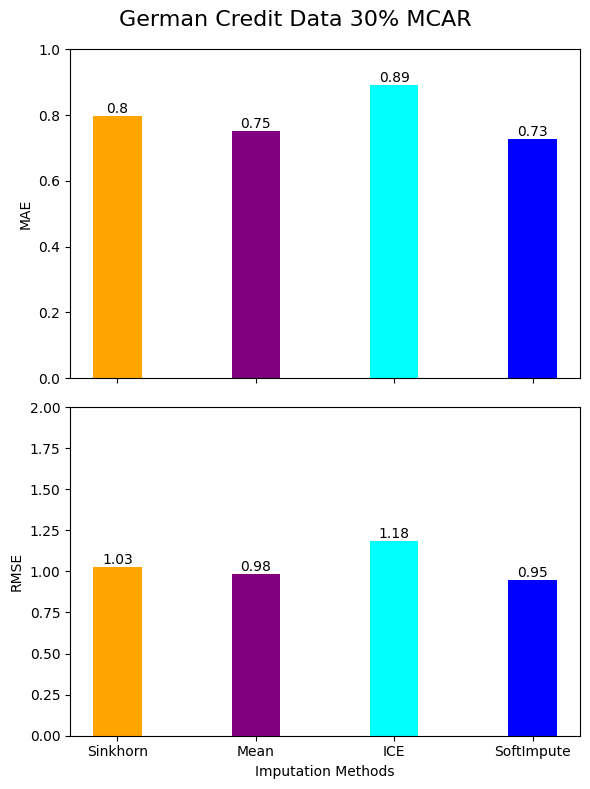

In [ ]:

# Define values and categories
values_mae_mcar30 = [sk_mae_mcar30, mean_mae_mcar30, ice_mae_mcar30, soft_mae_mcar30]
values_rmse_mcar30 = [sk_rmse_mcar30, mean_rmse_mcar30, ice_rmse_mcar30, soft_rmse_mcar30]
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
colors = ['orange', 'purple', 'cyan', 'blue']

# Bar chart parameters
bar_width = 0.35 # Width of each bar
index = np.arange(len(categories))  # Index for positioning bars

# Create subplots
fig2, (ax3, ax4) = plt.subplots(2, 1, figsize=(6, 8), sharex=True)
fig2.suptitle('German Credit Data 30% MCAR', fontsize=16)

bars3 = ax3.bar(index, values_mae_mcar30, color=colors, width=bar_width)
ax3.set_ylabel("MAE")
ax3.set_ylim(0, 1)  # Adjust based on your data
for bar in bars3:
    yval = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

bars4 = ax4.bar(index, values_rmse_mcar30, color=colors, width=bar_width)
ax4.set_ylabel("RMSE")
ax4.set_ylim(0, 2)  # Adjust based on your data
for bar in bars4:
    yval = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom')

ax4.set_xticks(index)
ax4.set_xticklabels(categories)
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


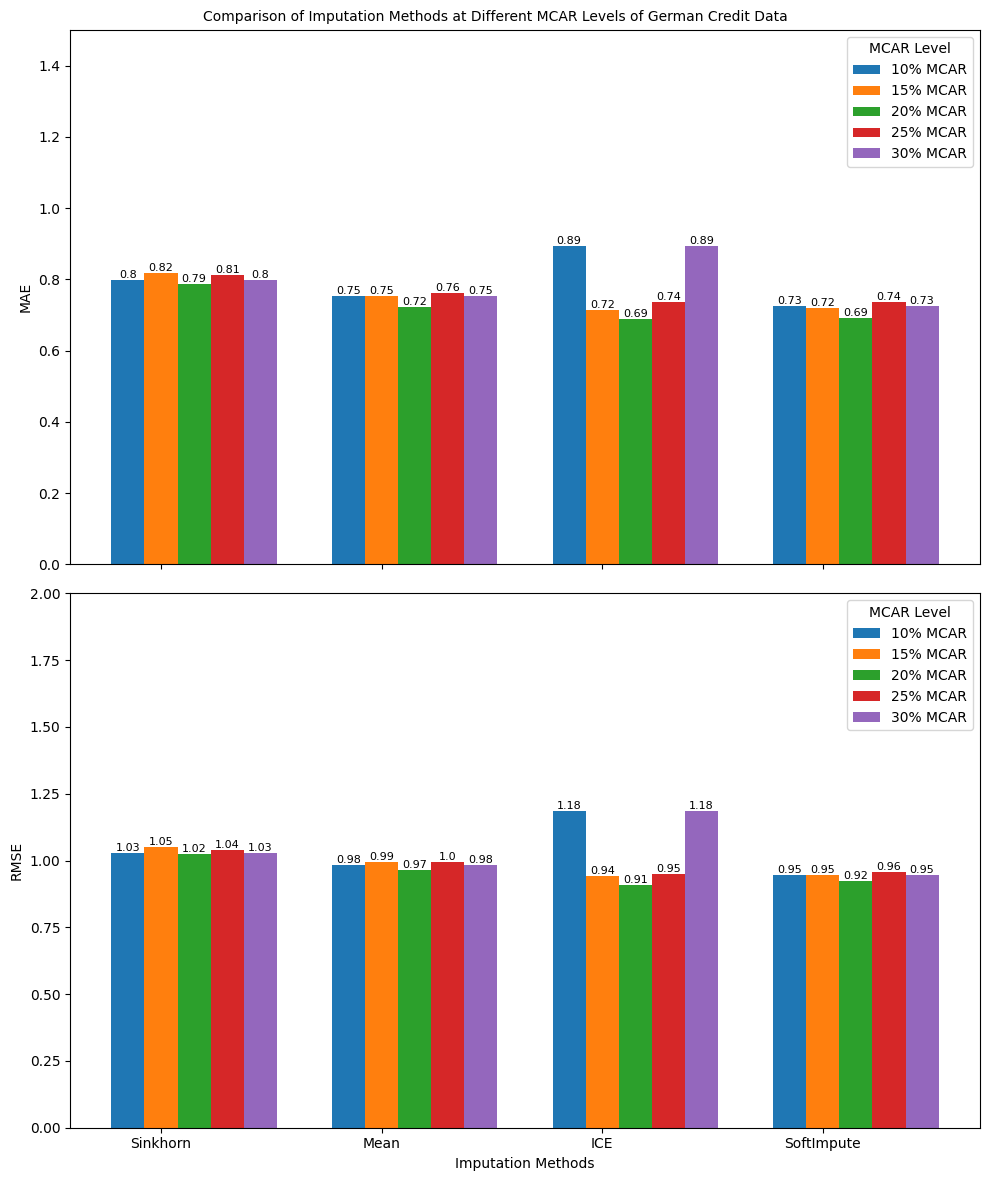

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define values for each MCAR percentage
values_mae_mcar10 = [sk_mae_mcar10, mean_mae_mcar10, ice_mae_mcar10, soft_mae_mcar10]  # MAE for 10% MCAR
values_rmse_mcar10 = [sk_rmse_mcar10, mean_rmse_mcar10, ice_rmse_mcar10, soft_rmse_mcar10]  # RMSE for 10% MCAR

values_mae_mcar15 = [sk_mae_mcar15, mean_mae_mcar15, ice_mae_mcar15, soft_mae_mcar15]  # MAE for 15% MCAR
values_rmse_mcar15 = [sk_rmse_mcar15, mean_rmse_mcar15, ice_rmse_mcar15, soft_rmse_mcar15]  # RMSE for 15% MCAR

values_mae_mcar20 = [sk_mae_mcar20, mean_mae_mcar20, ice_mae_mcar20, soft_mae_mcar20]  # MAE for 20% MCAR
values_rmse_mcar20 = [sk_rmse_mcar20, mean_rmse_mcar20, ice_rmse_mcar20, soft_rmse_mcar20]  # RMSE for 20% MCAR

values_mae_mcar10 = [sk_mae_mcar25, mean_mae_mcar25, ice_mae_mcar25, soft_mae_mcar25]  # MAE for 25% MCAR
values_rmse_mcar10 = [sk_rmse_mcar25, mean_rmse_mcar25, ice_rmse_mcar25, soft_rmse_mcar25]  # RMSE for 25% MCAR

values_mae_mcar10 = [sk_mae_mcar30, mean_mae_mcar30, ice_mae_mcar30, soft_mae_mcar30]  # MAE for 30% MCAR
values_rmse_mcar10 = [sk_rmse_mcar30, mean_rmse_mcar30, ice_rmse_mcar30, soft_rmse_mcar30]  # RMSE for 30% MCAR

# Combine the MAE and RMSE data for each MCAR level
values_mae = [values_mae_mcar10, values_mae_mcar15, values_mae_mcar20, values_mae_mcar25, values_mae_mcar30]
values_rmse = [values_rmse_mcar10, values_rmse_mcar15, values_rmse_mcar20,values_rmse_mcar25,values_rmse_mcar30]

# Define categories and x-axis labels
categories = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
mcar_labels = ['10% MCAR', '15% MCAR', '20% MCAR','25% MCAR','30% MCAR']
num_methods = len(categories)
bar_width = 0.15  # Width of each bar
x = np.arange(num_methods)  # X locations for the methods

# Create subplots for MAE and RMSE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of Imputation Methods at Different MCAR Levels of German Credit Data', fontsize=10)

# Plot MAE bars for each MCAR level
for i, (mcar, mae_values) in enumerate(zip(mcar_labels, values_mae)):
    ax1.bar(x + i * bar_width, mae_values, bar_width, label=mcar)

# Customize MAE plot
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1.5)  # Adjust based on your data
ax1.set_xticks(x + bar_width)  # Center x-ticks
ax1.set_xticklabels(categories)
ax1.legend(title="MCAR Level")

# Add values on top of MAE bars
for i, mae_values in enumerate(values_mae):
    for j, value in enumerate(mae_values):
        ax1.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom',fontsize=8)

# Plot RMSE bars for each MCAR level
for i, (mcar, rmse_values) in enumerate(zip(mcar_labels, values_rmse)):
    ax2.bar(x + i * bar_width, rmse_values, bar_width, label=mcar)

# Customize RMSE plot
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
ax2.set_xticks(x + bar_width)  # Center x-ticks
ax2.set_xticklabels(categories)
ax2.legend(title="MCAR Level")

# Add values on top of RMSE bars
for i, rmse_values in enumerate(values_rmse):
    for j, value in enumerate(rmse_values):
        ax2.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom',fontsize=8)

# Show the plot
plt.xlabel('Imputation Methods')
plt.tight_layout()
plt.show()


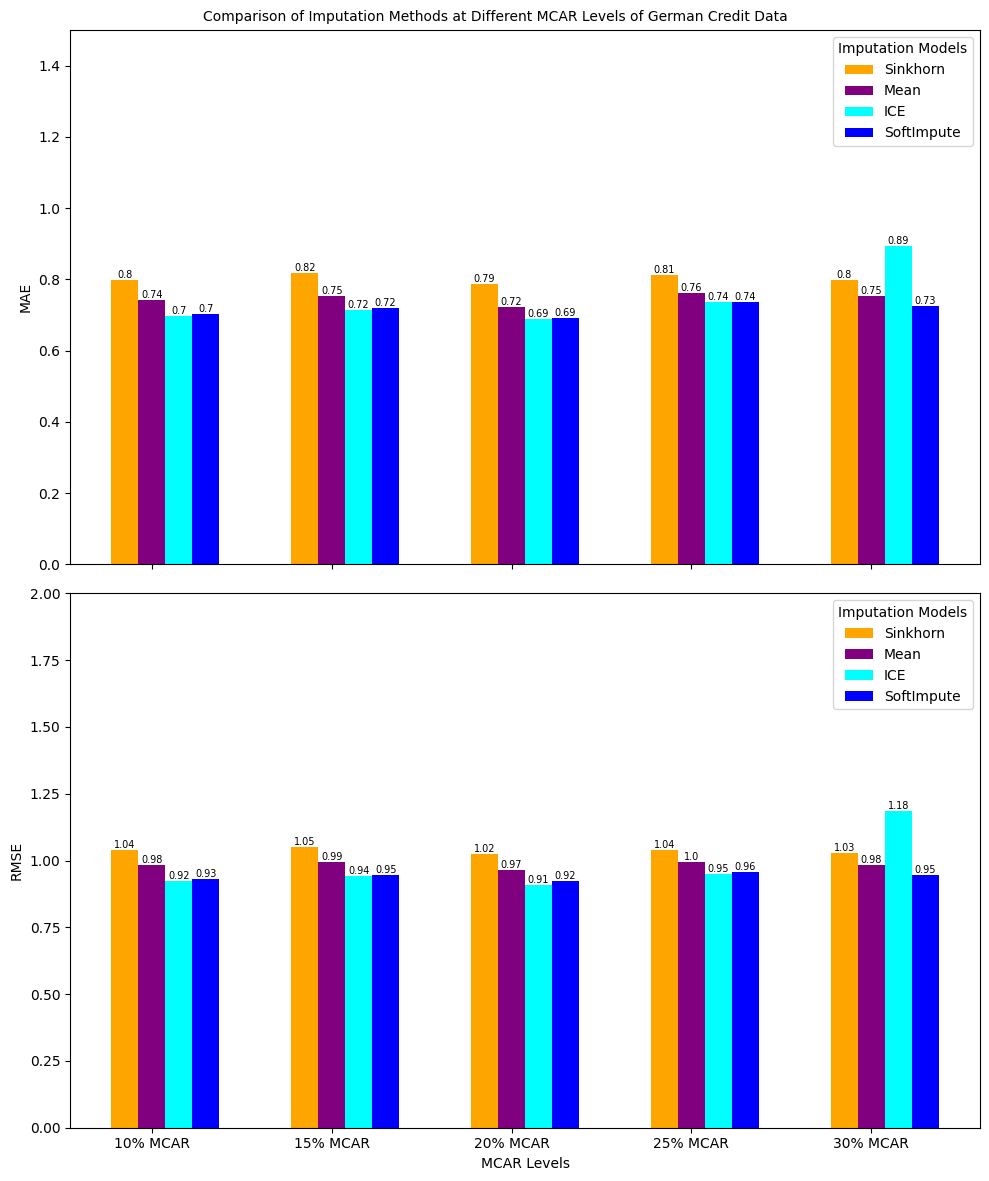

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define your MAE and RMSE data
sk_mcar_mae = [sk_mae_mcar10, sk_mae_mcar15, sk_mae_mcar20, sk_mae_mcar25, sk_mae_mcar30]
mean_mcar_mae = [mean_mae_mcar10, mean_mae_mcar15, mean_mae_mcar20, mean_mae_mcar25, mean_mae_mcar30]
ice_mcar_mae = [ice_mae_mcar10, ice_mae_mcar15, ice_mae_mcar20, ice_mae_mcar25, ice_mae_mcar30]
soft_mcar_mae = [soft_mae_mcar10, soft_mae_mcar15, soft_mae_mcar20, soft_mae_mcar25, soft_mae_mcar30]

sk_mcar_rmse = [sk_rmse_mcar10, sk_rmse_mcar15, sk_rmse_mcar20, sk_rmse_mcar25, sk_rmse_mcar30]
mean_mcar_rmse = [mean_rmse_mcar10, mean_rmse_mcar15, mean_rmse_mcar20, mean_rmse_mcar25, mean_rmse_mcar30]
ice_mcar_rmse = [ice_rmse_mcar10, ice_rmse_mcar15, ice_rmse_mcar20, ice_rmse_mcar25, ice_rmse_mcar30]
soft_mcar_rmse = [soft_rmse_mcar10, soft_rmse_mcar15, soft_rmse_mcar20, soft_rmse_mcar25, soft_rmse_mcar30]

# Combine the MAE and RMSE data for each MCAR level
values_mae = [sk_mcar_mae, mean_mcar_mae, ice_mcar_mae, soft_mcar_mae]
values_rmse = [sk_mcar_rmse, mean_mcar_rmse, ice_mcar_rmse, soft_mcar_rmse]

# Define categories, x-axis labels, and colors
categories = ['10% MCAR', '15% MCAR', '20% MCAR', '25% MCAR', '30% MCAR']
colors = ['orange', 'purple', 'cyan', 'blue']  # Yellow for Sinkhorn, purple for Mean, cyan for ICE, blue for SoftImpute
imputation_models = ['Sinkhorn', 'Mean', 'ICE', 'SoftImpute']
num_methods = len(categories)
bar_width = 0.15  # Width of each bar
x = np.arange(num_methods)  # X locations for the methods

# Create subplots for MAE and RMSE
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)
fig.suptitle('Comparison of Imputation Methods at Different MCAR Levels of German Credit Data', fontsize=10)

# Plot MAE bars for each MCAR level with custom colors
for i, (mcar, mae_values, color) in enumerate(zip(imputation_models, values_mae, colors)):
    ax1.bar(x + i * bar_width, mae_values, bar_width, label=mcar, color=color)

# Customize MAE plot
ax1.set_ylabel("MAE")
ax1.set_ylim(0, 1.5)  # Adjust based on your data
ax1.set_xticks(x + bar_width)  # Center x-ticks
ax1.set_xticklabels(categories)
ax1.legend(title="Imputation Models")

# Add values on top of MAE bars
for i, mae_values in enumerate(values_mae):
    for j, value in enumerate(mae_values):
        ax1.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=7)

# Plot RMSE bars for each MCAR level with custom colors
for i, (mcar, rmse_values, color) in enumerate(zip(imputation_models, values_rmse, colors)):
    ax2.bar(x + i * bar_width, rmse_values, bar_width, label=mcar, color=color)

# Customize RMSE plot
ax2.set_ylabel("RMSE")
ax2.set_ylim(0, 2)  # Adjust based on your data
ax2.set_xticks(x + bar_width)  # Center x-ticks
ax2.set_xticklabels(categories)
ax2.legend(title="Imputation Models")

# Add values on top of RMSE bars
for i, rmse_values in enumerate(values_rmse):
    for j, value in enumerate(rmse_values):
        ax2.text(j + i * bar_width, value, round(value, 2), ha='center', va='bottom', fontsize=7)

# Show the plot
plt.xlabel('MCAR Levels')
plt.tight_layout()
plt.show()
